# Multi-Task Learning (MTL) Basics Tutorial

Multi-task learning is becoming a standard tool for the modern ML practioner. A major requirement of this approach is the ability to easily *add new datasets, label sets, tasks, and metrics* (and just as easily remove them). Thus, in the Snorkel multi-task model design, each of these concepts have been decoupled.

The purpose of this tutorial is to introduce the basic interfaces and flow of the multi-task learning tools within Snorkel (we assume that you have prior experience with MTL, so we don't motivate or explain multi-task learning at large here.

In this notebook, we'll look at a simple MTL model with only two tasks, each having distinct data and only one set of ground truth labels ("gold" labels). We'll also use data where the raw data is directly usable as features, for simplicity (i.e., unlike text data, where we would first need to tokenize and transform the data into token ids).

## Environment Setup

In [1]:
%matplotlib inline

from snorkel.analysis.utils import set_seed

SEED = 123
set_seed(SEED)

## Create Toy Data

We'll now create a toy dataset to work with.
Our data points are 2D points in a square centered on the origin.
Our tasks will be classifying whether these points are:

1. Inside a **unit circle** centered on the origin
2. Inside a **unit square** centered on the origin

We'll visualize these decision boundaries in a few cells.

_Note: In this toy example, we don't expect these specific tasks to help each other learn, but this is often a benefit of joint training in MTL settings._

In [2]:
import numpy as np

N = 500  # Data points per dataset
R = 1  # Unit distance

# Dataset 0 ("circle")
circle_data = np.random.uniform(0, 1, size=(N, 2)) * 2 - 1
circle_labels = circle_data[:, 0] ** 2 + circle_data[:, 1] ** 2 < R

# Dataset 1 ("square")
square_data = np.random.uniform(0, 1, size=(N, 2)) * 2 - 1
square_labels = (abs(square_data[:, 0]) < 0.5) * (abs(square_data[:, 1]) < 0.5)

Note that, as is the case throughout the Snorkel repo, the **label -1 is reserved for abstaining/no label**; all actual labels have non-negative integer values: 0, 1, 2, .... This provides flexibility for supervision sources to label only portions of a dataset, for example.

And we can view the ground truth labels of our tasks visually to confirm our intuition on what the decision boundaries look like.

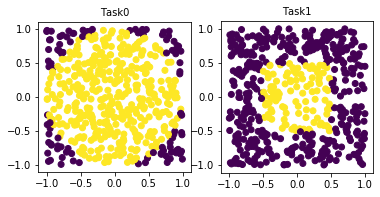

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

axs[0].scatter(circle_data[:, 0], circle_data[:, 1], c=circle_labels)
axs[0].set_aspect("equal", "box")
axs[0].set_title("Task0", fontsize=10)

axs[1].scatter(square_data[:, 0], square_data[:, 1], c=square_labels)
axs[1].set_aspect("equal", "box")
axs[1].set_title("Task1", fontsize=10)

plt.show()

Here, we wrap the `train_test_split` function to split the data into train/valid/test splits.

In [4]:
from sklearn.model_selection import train_test_split


def split_data(data, labels, seed=123):
    """Split data twice using sklearn train_test_split helper."""

    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.2, random_state=SEED
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=SEED
    )

    return (
        {"train": X_train, "valid": X_val, "test": X_test},
        {"train": y_train, "valid": y_val, "test": y_test},
    )

We'll now divide the synthetic `circle_data` and `square_data` into train/valid/test splits using our helper function `split_data()`.

In [5]:
circle_data_splits, circle_label_splits = split_data(
    circle_data, circle_labels, seed=SEED
)
square_data_splits, square_label_splits = split_data(
    square_data, square_labels, seed=SEED
)

## Make DataLoaders

With our data now loaded/created, we can now package it up into `DictDataset`s for training. This object is a simple wrapper around `torch.utils.data.Dataset` and stores data fields and labels as dictionaries.

In the `DictDataset`, each label corresponds to a particular `Task` by name.  We'll define these `Task` objects in the following section as we define our model.

`DictDataloader` is a wrapper for `torch.utils.data.Dataloader`, which handles the collate function for `DictDataset` appropriately.

In [6]:
import torch
from snorkel.classification.data import DictDataset, DictDataLoader

dataloaders = []
for split in ["train", "valid", "test"]:
    X_dict = {"circle_data": torch.FloatTensor(circle_data_splits[split])}
    Y_dict = {"circle_task": torch.LongTensor(circle_label_splits[split])}
    dataset = DictDataset("CircleDataset", split, X_dict, Y_dict)
    dataloader = DictDataLoader(dataset, batch_size=32)
    dataloaders.append(dataloader)

for split in ["train", "valid", "test"]:
    X_dict = {"square_data": torch.FloatTensor(square_data_splits[split])}
    Y_dict = {"square_task": torch.LongTensor(square_label_splits[split])}
    dataset = DictDataset("SquareDataset", split, X_dict, Y_dict)
    dataloader = DictDataLoader(dataset, batch_size=32)
    dataloaders.append(dataloader)

We now have 6 data loaders, one for each task (`circle_task` and `square_task`) for each split (`train`, `valid`, `test`).

## Define Model

Now we'll define the `SnorkelClassifier`, which is build from a list of `Tasks`.

### Tasks

A `Task` represents a path through a neural network. In `SnorkelClassifier`, this path corresponds to a particular sequence of PyTorch modules through which each example will make a forward pass.

To specify this sequence of modules, each `Task` defines a **module pool** (a set of modules that it relies on) and a **task flow**—a sequence of `Operation`s. Each `Operation` defines a module and the inputs to feed to that module. These inputs are described with a list of tuples, where each tuple is either (`_input_`, \[field_name\]), or the name of a previous operation and the index of its output to use (most modules have only a single output, so the second element of these tuples is almost always 0).

For example, below we define the module pool and task flow for the circle task:

In [7]:
import torch.nn as nn
from snorkel.classification.task import Operation

# Define a two-layer MLP module and a one-layer prediction "head" module
base_mlp = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 4), nn.ReLU())
head_module = nn.Linear(4, 2)

# The module pool contains all the modules this task uses
module_pool = nn.ModuleDict({"base_mlp": base_mlp, "circle_head_module": head_module})

# "From the input dictionary, pull out 'circle_data' and send it through input_module"
op1 = Operation(
    name="base_mlp", module_name="base_mlp", inputs=[("_input_", "circle_data")]
)

# "From the output of op1 (the input op), pull out the 0th indexed output
# (i.e., the only output) and send it through the head_module"
op2 = Operation(
    name="circle_head", module_name="circle_head_module", inputs=[("base_mlp", 0)]
)

task_flow = [op1, op2]

The output of the final module in that sequence will then go into a `loss_func()` to calculate the loss (e.g., cross-entropy) during training or an `output_func()` (e.g., softmax) to convert the logits into a prediction. Each of these functions accepts as the first argument the final `module_name` to indicate inputs—we indicate this with the `partial(fn, module_name)` syntax.

Each `Task` also specifies which metrics it supports, which are bundled together in a `Scorer` object. For this tutorial, we'll just look at accuracy.

Putting this all together, we define the circle task:

In [8]:
from functools import partial

from snorkel.classification.task import Task, ce_loss, softmax
from snorkel.classification.scorer import Scorer

circle_task = Task(
    name="circle_task",
    module_pool=module_pool,
    task_flow=task_flow,
    loss_func=partial(ce_loss, "circle_head"),
    output_func=partial(softmax, "circle_head"),
    scorer=Scorer(metrics=["accuracy"]),
)

Note that `Task` objects are not dependent on a particular dataset; multiple datasets can be passed through the same modules for pre-training or co-training.

We'll now define the square task, but more succinctly—for example, using the fact that the default name for an `Operation` is its `module_name` (since most tasks only use their modules once per forward pass).

We'll also define the square task to share the first module in its task flow (`base_mlp`) with the circle task to demonstrate how to share modules. (Note that this is purely for illustrative purposes; for this toy task, it is very possible that this is not the optimal arrangement of modules).

Finally, the most common task definitions we see in practice are classification tasks with cross-entropy loss and softmax on the output of the last module, and accuracy is most often the primary metric of interest, these are all the default values, so we can drop them here for brevity.

In [9]:
square_task = Task(
    name="square_task",
    module_pool=nn.ModuleDict({"base_mlp": base_mlp, "square_head": nn.Linear(4, 2)}),
    task_flow=[
        Operation("base_mlp", [("_input_", "square_data")]),
        Operation("square_head", [("base_mlp", 0)]),
    ],
    scorer=Scorer(metrics=["accuracy"]),
)

## Model

With our tasks defined, constructing a model is simple: we simply pass the list of tasks in and the model constructs itself using information from the task flows.

Note that the model uses the names of modules (not the modules themselves) to determine whether two modules specified by separate tasks are the same module (and should share weights) or different modules (with separate weights).
So because both the `square_task` and `circle_task` include "base_mlp" in their module pools, this module will be shared between the two tasks.

In [10]:
from snorkel.classification.snorkel_classifier import SnorkelClassifier

model = SnorkelClassifier([circle_task, square_task])

### Train Model

Once the model is constructed, we can train it as we would a single-task model, using the `train_model` method of a `Trainer` object. The `Trainer` supports multiple schedules or patterns for sampling from different dataloaders; the default is to randomly sample from them proportional to their number of batches, such that all examples  will be seen exactly once before any are seen twice.

In [11]:
from snorkel.classification.training import Trainer

trainer_config = {"progress_bar": True, "n_epochs": 10, "lr": 0.02}

trainer = Trainer(**trainer_config)
trainer.train_model(model, dataloaders)

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.79, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.765, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.702, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.699, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.676, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.671, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.665, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.647, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.647, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.631, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.614, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.595, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.597, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.586, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.578, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.579, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.576, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.566, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.564, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.562, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.562, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.557, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.554, model/all/train/lr=0.02]

Epoch 0::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.555, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 0:: 100%|██████████| 24/24 [00:00<00:00, 273.44it/s, model/all/train/loss=0.555, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]


Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.535, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.571, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.572, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.588, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.618, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.589, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.591, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.595, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.57, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675] 

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.577, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.566, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.574, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.559, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.54, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675] 

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.532, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.531, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.536, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.536, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.528, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.524, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.522, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.524, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.523, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.523, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 1:: 100%|██████████| 24/24 [00:00<00:00, 330.67it/s, model/all/train/loss=0.523, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]


Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.526, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.544, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.573, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.543, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.541, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.515, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.531, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.544, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.545, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.536, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.542, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.544, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.552, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.549, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.536, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.519, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.511, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.508, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.506, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.505, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.497, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.496, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.496, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.498, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 2:: 100%|██████████| 24/24 [00:00<00:00, 327.48it/s, model/all/train/loss=0.498, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]


Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.516, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.512, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.543, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.539, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.542, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.552, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.515, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.518, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.53, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675] 

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.522, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.496, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.487, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.497, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.494, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.499, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.498, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.488, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.487, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.477, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.475, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.474, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.477, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.475, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.475, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 3:: 100%|██████████| 24/24 [00:00<00:00, 337.50it/s, model/all/train/loss=0.475, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]


Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.494, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.499, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.485, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.517, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.52, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675] 

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.515, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.505, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.501, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.498, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.488, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.468, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.478, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.461, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.459, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.464, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.462, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.452, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.45, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675] 

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.45, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.448, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.451, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.441, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.439, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.85, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 4::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.438, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675] 

Epoch 4:: 100%|██████████| 24/24 [00:00<00:00, 356.43it/s, model/all/train/loss=0.438, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]


Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.463, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.457, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.506, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.483, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.475, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.475, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.476, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.468, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.463, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.458, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.439, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.451, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.435, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.432, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.438, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.427, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.426, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.427, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.425, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.423, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.425, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.414, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.412, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.675]

Epoch 5::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.412, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]  

Epoch 5:: 100%|██████████| 24/24 [00:00<00:00, 335.80it/s, model/all/train/loss=0.412, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]


Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.433, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.407, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.412, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.42, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7] 

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.429, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.423, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.416, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.429, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.424, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.406, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.389, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.386, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.376, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.385, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.386, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.385, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.387, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.386, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.374, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.375, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.372, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.371, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.372, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.9, square_task/SquareDataset/valid/accuracy=0.7]

Epoch 6::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.371, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 6:: 100%|██████████| 24/24 [00:00<00:00, 373.63it/s, model/all/train/loss=0.371, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]


Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.311, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.334, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.346, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.353, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.358, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.352, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.347, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.356, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.336, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.317, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.319, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.308, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.309, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.317, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.319, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.319, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.316, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.306, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.307, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.309, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.307, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.307, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.307, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.825]

Epoch 7::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.307, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]  

Epoch 7:: 100%|██████████| 24/24 [00:00<00:00, 418.99it/s, model/all/train/loss=0.307, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]


Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.233, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.264, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.276, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.272, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.272, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.277, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.287, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.285, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.269, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.272, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.257, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.258, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.263, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.266, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.26, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9] 

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.258, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.259, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.262, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.259, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.26, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9] 

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.26, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.255, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.255, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.9]

Epoch 8::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.255, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 8:: 100%|██████████| 24/24 [00:00<00:00, 433.11it/s, model/all/train/loss=0.255, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]


Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.224, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.252, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.234, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.241, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.246, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.246, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.254, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.253, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.237, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.24, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95] 

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.227, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.221, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.218, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.219, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.222, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.225, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.222, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.223, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.226, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.22, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95] 

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.221, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.223, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.223, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.95]

Epoch 9::   0%|          | 0/24 [00:00<?, ?it/s, model/all/train/loss=0.223, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.975]

Epoch 9:: 100%|██████████| 24/24 [00:00<00:00, 437.22it/s, model/all/train/loss=0.223, model/all/train/lr=0.02, circle_task/CircleDataset/valid/accuracy=0.925, square_task/SquareDataset/valid/accuracy=0.975]

### Evaluate model

After training, we can call the model.score() method to see the final performance of our trained model.

In [12]:
model.score(dataloaders)

{'circle_task/CircleDataset/train/accuracy': 0.9277777777777778,
 'circle_task/CircleDataset/valid/accuracy': 0.925,
 'circle_task/CircleDataset/test/accuracy': 0.94,
 'square_task/SquareDataset/train/accuracy': 0.9611111111111111,
 'square_task/SquareDataset/valid/accuracy': 0.975,
 'square_task/SquareDataset/test/accuracy': 0.95}

Task-specific metrics are recorded in the form `task/dataset/split/metric` corresponding to the task the made the predictions, the dataset the predictions were made on, the split being evaluated, and the metric being calculated.

For model-wide metrics (such as the total loss over all tasks or the learning rate), the default task name is `model` and the dataset name is `all` (e.g. `model/all/train/loss`).

# Your Turn

To check your understanding of how to use the multi-task `SnorkelClassifier`, see if you can add a task to this multi-task model.

In this case, we'll pretend that we have training data for this third task, but no test data; that is, its only purpose is to provide additional training signal that might be helpful for the other two tasks.

We'll generate the data for you: let's call it the `inv_circle_task`, since it will have the same distribution as our circle data, but with the inverted (flipped) labels.
Intuitively, a model that is very good at telling whether a point is within a certain region should also be very good at telling if it's outside the region.

By sharing some layers (the `base_mlp`), this new task will help the model to learn a representation that benefits the `circle_task` as well.
And because it will have a non-shared layer (call it the `inv_circle_head`), it will have the flexibility to map that good representation into the right label space for its own task.

### Create the data

In [13]:
# We flip the inequality when generating the labels so that our positive class is now _outside_ the circle.

inv_circle_data = torch.FloatTensor(np.random.uniform(0, 1, size=(N, 2)) * 2 - 1)
inv_circle_labels = (inv_circle_data[:, 0] ** 2 + inv_circle_data[:, 1] ** 2 > R).long()

### Create the DictDataLoader

Create the `DictDataLoader` for this new dataset.
- The X_dict should map data field names to data (in this case, we only need one field, since our data is represented by a single Tensor). You can name the field whatever you want; you'll just need to make sure that your `Task` object refers to the right field name in its task flow.
- The Y_dict should map a task name to a set of labels. This will tell the model what path through the network to use when making predictions or calculating loss on batches from this dataset. At this point we haven't yet defined our

In [14]:
X_dict = {}  # Replace this with the correct definition
Y_dict = {}  # Replace this with the correct definition
inv_dataset = DictDataset("InvCircleDataset", "train", X_dict, Y_dict)
inv_dataloader = DictDataLoader(inv_dataset, batch_size=32)

We add this new dataloader to the dataloaders for the other tasks.

In [15]:
all_dataloaders = dataloaders + [inv_dataloader]

### Create the task

Using the `square_task` definition as a template, fill in the arguments for an `inverse_circle_task` that consists of the same `base_mlp` module as the other tasks and a separate linear head with an output of size 2.

In [16]:
# Uncomment and fill in the arguments to the Task object to define the inverse_circle task.
# inv_circle_task = Task()

### Create the model

Once we have our task objects, creating the new multi-task model is as easy as adding the new task to the list of tasks at model initialization time.

In [17]:
# Uncomment and run the following line.
# model = SnorkelClassifier([circle_task, square_task, inv_circle_task])

### Train the model

We can use the same trainer and training settings as before.

In [18]:
# trainer.train_model(model, all_dataloaders)
# model.score(all_dataloaders)

### Validation

If you successfully added the appropriate task, the previous command should have succesfully trained and reported scores in the high 90s for all datasets and splits, including for the new `inv_circle_task`.
The following assert statement should also pass if you uncomment and run it.

In [19]:
# assert len(model.module_pool) == 4  # 1 shared module plus 3 separate task heads

## Summary

In this tutorial, we demonstrated how to specify arbitrary flows through a network with  multiple datasets, providing the flexiblity to easily implement design patterns such as multi-task learning. On this toy task with only two simple datasets and very simple hard parameter sharing (a shared trunk with different heads), the utility of this design may be less apparent. However, for more complicated network structures (e.g., slicing) or scenarios with frequent changing of the structure (e.g., due to popping new tasks on/off a massive MTL model), the flexibility of this design starts to shine. If there's an MTL network you'd like to build but can't figure out how to represent, post an issue and let us know!